In [1]:
# !pip install SimpleITK
!pip install torchio
!pip install itk
!pip install itkwidgets

     |████████████████████████████████| 172 kB 901 kB/s 
     |████████████████████████████████| 52.7 MB 68.4 MB/s 
     |████████████████████████████████| 237 kB 57.9 MB/s 
     |████████████████████████████████| 51 kB 6.7 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.7.4.3
    Uninstalling typing-extensions-3.7.4.3:
      Successfully uninstalled typing-extensions-3.7.4.3
  Attempting uninstall: SimpleITK
    Found existing installation: SimpleITK 2.0.2
    Uninstalling SimpleITK-2.0.2:
      Successfully uninstalled SimpleITK-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.4.1 requires typing-extensions~=3.7.4, but you have typing-extensions 4.4.0 which is incompatible.
arviz 0.11.2 requires typing-extensions<4,>=3.7.4.3, but you have typing-extensions 4.4.0 which is incompatible.
aiob

In [2]:
import os
import numpy as np
import pandas as pd
import gc
import time
from scipy.signal import gaussian, convolve2d
import matplotlib.pyplot as plt
import SimpleITK as sitk
from tqdm import tqdm
import plotly.graph_objects as go
import numpy as np
import SimpleITK
from keras.utils.np_utils import to_categorical,normalize
from keras.models import Model
from keras.layers import MaxPooling2D,Conv2D,Dense,BatchNormalization,Concatenate,Input,Dropout,Maximum,Activation,Dense,Flatten,UpSampling2D,Conv2DTranspose,Add,Multiply,Lambda
from keras.optimizers import SGD,Adam,RMSprop
import keras.callbacks as callbacks
import keras.initializers as initializers
from keras.callbacks import Callback
from keras import regularizers
from keras import backend as K
import getopt
from keras.models import Model, load_model
from keras.layers import Input ,BatchNormalization , Activation 
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from PIL import Image
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten 
from keras.layers import Dense
import cv2 as cv
from keras import optimizers 
import sys
import nibabel as nib       
import time
from skimage.io import imread, imshow
import itk                                                                
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
from skimage.util import montage 
from skimage.transform import rotate
from PIL import Image
from numba import njit,prange
import cv2
import torchio as tio
from sklearn.model_selection import train_test_split
%matplotlib inline

# 1. Brats 2018 3D Data

In [3]:
path = '../input/brats2018/MICCAI_BraTS_2018_Data_Training/HGG/'

number_of_files = 10
nf = number_of_files

def load_data(path):
    my_dir = sorted(os.listdir(path)[:nf])
    data = []
    gt = []
    for p in tqdm(my_dir):
        data_list = sorted(os.listdir(path+p))
        if len(data_list)==5:
            img_itk = sitk.ReadImage(path + p + '/'+ data_list[0])
            flair = sitk.GetArrayFromImage(img_itk)
            img_itk = sitk.ReadImage(path + p + '/'+ data_list[1])
            seg =  sitk.GetArrayFromImage(img_itk)
            img_itk = sitk.ReadImage(path + p + '/'+ data_list[2])
            t1 =  sitk.GetArrayFromImage(img_itk)
            img_itk = sitk.ReadImage(path + p + '/'+ data_list[3])
            t1ce =  sitk.GetArrayFromImage(img_itk)
            img_itk = sitk.ReadImage(path + p + '/'+ data_list[4])
            t2 =  sitk.GetArrayFromImage(img_itk)
            data.append([flair,t1,t1ce,t2])
            gt.append(seg)
        else:pass
    data = np.asarray(data,dtype=np.float32)
    gt = np.asarray(gt,dtype=np.uint8)
    return data, gt

data, gt = load_data(path)

100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


In [4]:
gc.collect()

51

# Visualization

(-0.5, 191.5, 191.5, -0.5)

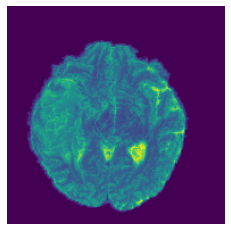

In [5]:
def sobel(img):
    Gx= np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Gy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    img_sobelx = cv2.Sobel(img, cv2.CV_8U,1,0,ksize=3)
    img_sobely = cv2.Sobel(img, cv2.CV_8U,0,1,ksize=3)
    img_sobel = img_sobelx + img_sobely+img
    return img_sobel

data_v = np.transpose(data,(0,2,3,4,1))
data_v = data_v[:,30:120,30:222,30:222,:].reshape([-1,192,192,4])
plt.imshow(sobel(data_v[40, :, :, 3]))
plt.axis("off")

4 TYPES OF MRI
 
          FLAIR                         T2                         T1                      T1CE


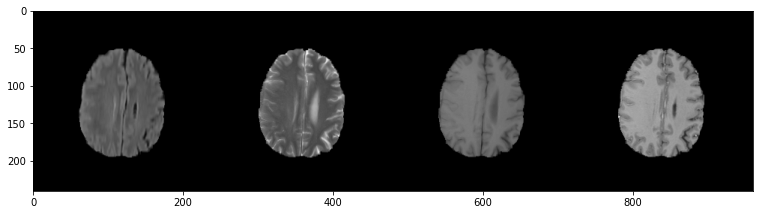

In [6]:
flair_path = "../input/brats2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_flair.nii"
t1_path = "../input/brats2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_t1.nii"
t2_path="../input/brats2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_t2.nii"
t1ce_path="../input/brats2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_t1ce.nii"

def sitk_show_grey(img, title=None, margin=0.0, dpi=40):
    nda = SimpleITK.GetArrayFromImage(img)
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1], nda.shape[0], 0)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    ax.imshow(nda,extent=extent,interpolation=None,cmap='gray')
    if title:
        plt.title(title)
    plt.show()
    
idxSlice = 105
labelGrayMatter = 1

flair_img = SimpleITK.ReadImage(flair_path)
t1_img = SimpleITK.ReadImage(t1_path)
t2_img = SimpleITK.ReadImage(t2_path)
t1ce_img = SimpleITK.ReadImage(t1ce_path)

print("4 TYPES OF MRI")
print(" ")
print(" "*10+"FLAIR"+" "*25+"T2"+" "*25+"T1"+" "*22+"T1CE")
sitk_show_grey(SimpleITK.Tile(flair_img[:, :, 105],
                         t2_img[:, :, 105],
                         t1_img[:, :, 105],
                         t1ce_img[:, :, 105],
                         (5, 1, 0)))

# 2.1 Wiener Filtering

In [7]:
class Wiener_filter():
    def blur(img, mode = 'box', block_size = 3):
        mode = 'box' or 'gaussian' or 'motion'
        dummy = np.copy(img)
        if mode == 'box':
            h = np.ones((block_size, block_size)) / block_size ** 2
        elif mode == 'gaussian':
            h = gaussian(block_size, block_size / 3).reshape(block_size, 1)
            h = np.dot(h, h.transpose())
            h /= np.sum(h)
        elif mode == 'motion':
            h = np.eye(block_size) / block_size
        dummy = convolve2d(dummy, h, mode = 'valid')
        return np.uint8(dummy), h
    def smoothening(path):
        data, gt = load_data(path)
        return data, gt
    def plot_filter(f,t2,t1,tc1):
        FSmooth = SimpleITK.CurvatureFlow(image1=f,
                                      timeStep=0.1,
                                      numberOfIterations=2)
        T2Smooth = SimpleITK.CurvatureFlow(image1=t2,
                                              timeStep=0.1,
                                              numberOfIterations=2)
        T1Smooth = SimpleITK.CurvatureFlow(image1=t1,
                                              timeStep=0.1,
                                              numberOfIterations=2)

        TCSmooth = SimpleITK.CurvatureFlow(image1=tc1,
                                              timeStep=0.1,
                                              numberOfIterations=2)
        print(" "*10+"FLAIR"+" "*25+"T2"+" "*25+"T1"+" "*22+"T1CE")
        sitk_show_grey(SimpleITK.Tile(FSmooth[:, :, 105], 
                         T2Smooth[:, :, 105], 
                         T1Smooth[:, :, 105], 
                         TCSmooth[:, :, 105],
                         (5, 1, 0)))
    def gaussian_add(img, sigma = 5):
        dummy = np.copy(img).astype(float)
        gauss = np.random.normal(0, sigma, np.shape(img))
        # Additive Noise
        dummy = np.round(gauss + dummy)
        # Saturate lower bound
        dummy[np.where(dummy < 0)] = 0
        # Saturate upper bound
        dummy[np.where(dummy > 255)] = 255
        return np.uint8(dummy)

# 2.2 Adaptive Median Filtering

In [8]:
class AMF():
    def analyzearray(image, size, window=1, threshold=0., spam=False):
        filter_window = 2*window + 1
        xlength, ylength = size
        vlength = filter_window*filter_window
        if spam:
            print('Image length in X direction: {}'.format(xlength))
            print('Image length in Y direction: {}'.format(ylength))
            print('Filter window size: {0} x {0}'.format(filter_window))

        image_array = np.reshape(np.array(image, dtype=np.uint8), (ylength, xlength))
        filter_window = np.array(np.zeros((filter_window, filter_window)))
        target_vector = np.array(np.zeros(vlength))
        pixel_count = 0

        try:
            for y in range(window, ylength-(window+1)):
                for x in range(window, xlength-(window+1)):
                    filter_window = image_array[y-window:y+window+1, x-window:x+window+1]
                    target_vector = np.reshape(filter_window, ((vlength),))
                    median = median_demo(target_vector, vlength)
                    if not threshold > 0:
                        image_array[y, x] = median
                        pixel_count += 1
                    else:
                        scale = np.zeros(vlength)
                        for n in range(vlength):
                            scale[n] = abs(int(target_vector[n]) - int(median))
                        scale = np.sort(scale)
                        Sk = 1.4826 * (scale[vlength//2])
                        if abs(int(image_array[y, x]) - int(median)) > (threshold * Sk):
                            image_array[y, x] = median
                            pixel_count += 1

        except TypeError as err:
            print('Error in processing function:'.format(err))
            sys.exit(2)
        print('{} pixel(s) filtered out of {}'.format(pixel_count, xlength*ylength))
        return np.reshape(image_array, (xlength*ylength)).tolist()

    @njit
    def median_demo(target_array, array_length):
        sorted_array = np.sort(target_array)
        median = sorted_array[array_length//2]
        return median
    def _Filtering(path):
        data, gt = load_data(path)
        return data, gt
    def process_images(data):
        my_dir = sorted(os.listdir(path)[:nf])
        data = []
        gt = []
        for p in tqdm(my_dir):
            data_list = sorted(os.listdir(path+p))
            if len(data_list)==5:
                img_itk = sitk.ReadImage(path + p + '/'+ data_list[0])
                img_itk = SimpleITK.CurvatureFlow(image1=img_itk,
                                          timeStep=0.125,
                                          numberOfIterations=1)
                flair = sitk.GetArrayFromImage(img_itk)
                img_itk = sitk.ReadImage(path + p + '/'+ data_list[1])
                img_itk = SimpleITK.CurvatureFlow(image1=img_itk,
                                          timeStep=0.125,
                                          numberOfIterations=1)
                seg =  sitk.GetArrayFromImage(img_itk)
                img_itk = sitk.ReadImage(path + p + '/'+ data_list[2])
                img_itk = SimpleITK.CurvatureFlow(image1=img_itk,
                                          timeStep=0.125,
                                          numberOfIterations=1)
                t1 =  sitk.GetArrayFromImage(img_itk)
                img_itk = sitk.ReadImage(path + p + '/'+ data_list[3])
                img_itk = SimpleITK.CurvatureFlow(image1=img_itk,
                                          timeStep=0.125,
                                          numberOfIterations=1)
                t1ce =  sitk.GetArrayFromImage(img_itk)
                img_itk = sitk.ReadImage(path + p + '/'+ data_list[4])
                img_itk = SimpleITK.CurvatureFlow(image1=img_itk,
                                          timeStep=0.125,
                                          numberOfIterations=1)
                t2 =  sitk.GetArrayFromImage(img_itk)
                data.append([flair,t1,t1ce,t2])
                gt.append(seg)
            else:pass
        data = np.asarray(data,dtype=np.float32)
        gt = np.asarray(gt,dtype=np.uint8)
        data = np.transpose(data,(0,2,3,4,1))
        data = data[:,30:120,30:222,30:222,:].reshape([-1,192,192,4])
        gt = gt[:,30:120,30:222,30:222].reshape([-1,192,192,1])
        wdata = np.zeros_like(data)
        gt[np.where(gt==4)]=3
        return data, gt
    @njit
    def padding(img,pad):
        padded_img = np.zeros((img.shape[0]+2*pad,img.shape[1]+2*pad))
        padded_img[pad:-pad,pad:-pad] = img
        return padded_img

    @njit(parallel=True)
    def MedianFilter(img,s=3,sMax=7):
        if len(img.shape) == 3:
            raise Exception ("Single channel image only")

        H,W = img.shape
        a = sMax//2
        padded_img = padding(img,a)

        f_img = np.zeros(padded_img.shape)

        for i in prange(a,H+a+1):
            for j in range(a,W+a+1):
                value = Lvl_A(padded_img,i,j,s,sMax)
                f_img[i,j] = value

        return f_img[a:-a,a:-a]
    
    def _visualize(f,t2,t1,tc1):
        FSmooth = SimpleITK.CurvatureFlow(image1=f,
                                      timeStep=0.2,
                                      numberOfIterations=5)
        T2Smooth = SimpleITK.CurvatureFlow(image1=t2,
                                              timeStep=0.2,
                                              numberOfIterations=5)
        T1Smooth = SimpleITK.CurvatureFlow(image1=t1,
                                              timeStep=0.2,
                                              numberOfIterations=5)

        TCSmooth = SimpleITK.CurvatureFlow(image1=tc1,
                                              timeStep=0.2,
                                              numberOfIterations=5)
        print(" "*10+"FLAIR"+" "*25+"T2"+" "*25+"T1"+" "*22+"T1CE")
        sitk_show_grey(SimpleITK.Tile(FSmooth[:, :, 105], 
                         T2Smooth[:, :, 105], 
                         T1Smooth[:, :, 105], 
                         TCSmooth[:, :, 105],
                         (5, 1, 0)))
    @njit
    def Lvl_A(mat,x,y,s,sMax):
        window = mat[x-(s//2):x+(s//2)+1,y-(s//2):y+(s//2)+1]
        Zmin = np.min(window)
        Zmed = np.median(window)
        Zmax = np.max(window)

        A1 = Zmed - Zmin
        A2 = Zmed - Zmax

        if A1 > 0 and A2 < 0:
            return Lvl_B(window, Zmin, Zmed, Zmax)
        else:
            s += 2 
            if s <= sMax:
                return Lvl_A(mat,x,y,s,sMax)
            else:
                 return Zmed

    @njit
    def Lvl_B(window, Zmin, Zmed, Zmax):
        h,w = window.shape

        Zxy = window[h//2,w//2]
        B1 = Zxy - Zmin
        B2 = Zxy - Zmax

        if B1 > 0 and B2 < 0 :
            return Zxy
        else:
            return Zmed

In [9]:
path = '../input/brats2018/MICCAI_BraTS_2018_Data_Training/HGG/'# wienner
number_of_files = 20
nf = number_of_files

data, gt = AMF._Filtering(path)
data.shape, gt.shape

100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


((20, 4, 155, 240, 240), (20, 155, 240, 240))

In [10]:
gc.collect()

5931

# Before noise removal

          FLAIR                         T2                         T1                      T1CE


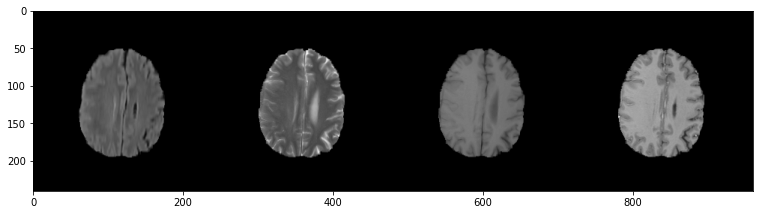

In [11]:
print(" "*10+"FLAIR"+" "*25+"T2"+" "*25+"T1"+" "*22+"T1CE")
sitk_show_grey(SimpleITK.Tile(flair_img[:, :, 105],
                         t2_img[:, :, 105],
                         t1_img[:, :, 105],
                         t1ce_img[:, :, 105],
                         (5, 1, 0)))

# After Wiener Filtering

          FLAIR                         T2                         T1                      T1CE


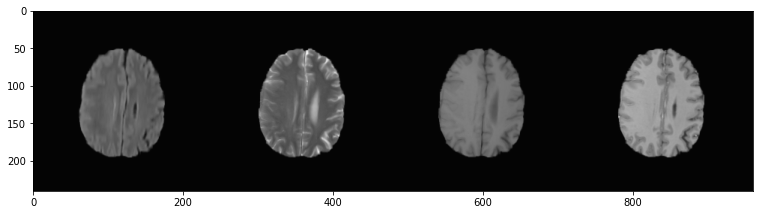

In [12]:
Wiener_filter.plot_filter(flair_img,t2_img,
               t1_img,t1ce_img)

# After AMF Filtering

          FLAIR                         T2                         T1                      T1CE


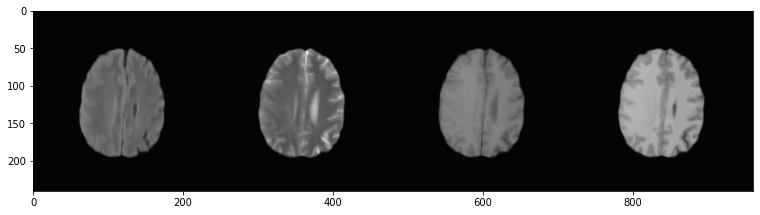

In [13]:
AMF._visualize(flair_img, t2_img, t1_img, t1ce_img)

In [14]:
data = np.transpose(data,(0,2,3,4,1))

dataseg = data.reshape([-1,240,240,4])

data = data[:,30:120,30:222,30:222,:].reshape([-1,192,192,4])
gt = gt[:,30:120,30:222,30:222].reshape([-1,192,192,1])

wdata = np.zeros_like(data)
gt[np.where(gt==4)]=3   #converting ground truth value of 4 to 3 => one hot encoding

data.shape, gt.shape

((1800, 192, 192, 4), (1800, 192, 192, 1))

In [15]:
gc.collect()

8068

# 3. Region Growing based K-Means Clustering

In [16]:
class RGKMC():
    def __init__(self,x,y):
        self.x = x
        self.y = y
    seg_model = ['kmeans', 'RGKMC']
    def clustering(img,currentPoint,tmpPoint):
        cl_n = 10
        kmean = kmeans(n_clusters= cl_n, random_state=0).fit(K)
        Labels = kmean.labels_
        Labels = Labels.reshape(240,240)
        desimg = np.zeros([240,240])
        for k in range(cl_n):
            blanktestimg = np.zeros([240,240])
            for i in range(240): 
                for j in range(240):
                    if (Labels[i][j] == k) :
                        blanktestimg[i][j] = 1
                        if(k==9):
                            desimg[i][j] = F[i][j]
    def adjustCentroids(centroids, clusters):
        new_centroids = []
        keys = sorted(clusters.keys())
        for k in keys:
            n = numpy.mean(clusters[k], axis=0)
            new = (int(n[0]), int(n[1]), int(n[2]))
            print(str(k) + ": " + str(new))
            new_centroids.append(new)
        return new_centroids
    def regionGrow(img,seeds,thresh,p = 1):
        height, weight = img.shape
        seedMark = np.zeros(img.shape)
        seedList = []
        for seed in seeds:
            seedList.append(seed)
        label = 1
        connects = selectConnects(p)
        while(len(seedList)>0):
            currentPoint = seedList.pop(0)
            seedMark[currentPoint.x,currentPoint.y] = label
            for i in range(8):
                tmpX = currentPoint.x + connects[i].x
                tmpY = currentPoint.y + connects[i].y
                if tmpX < 0 or tmpY < 0 or tmpX >= height or tmpY >= weight:
                    continue
                grayDiff = getGrayDiff(img,currentPoint,Point(tmpX,tmpY))
                if grayDiff < thresh and seedMark[tmpX,tmpY] == 0:
                    seedMark[tmpX,tmpY] = label
                    seedList.append(Point(tmpX,tmpY))
        return seedMark
    def kmeans_seg(input_shape):
        def Convolution(input_tensor,filters):
            x = Conv2D(filters=filters,kernel_size=(3, 3),padding = 'same',strides=(1, 1))(input_tensor)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            return x
        inputs = Input((input_shape))
        conv_1 = Convolution(inputs,32)
        maxp_1 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_1)
        conv_2 = Convolution(maxp_1,64)
        maxp_2 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_2)
        conv_3 = Convolution(maxp_2,128)
        maxp_3 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_3)
        conv_4 = Convolution(maxp_3,256)
        maxp_4 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_4)
        conv_5 = Convolution(maxp_4,512)
        upsample_6 = UpSampling2D((2, 2)) (conv_5)
        conv_6 = Convolution(upsample_6,256)
        upsample_7 = UpSampling2D((2, 2)) (conv_6)
        upsample_7 = concatenate([upsample_7, conv_3])
        conv_7 = Convolution(upsample_7,128)
        upsample_8 = UpSampling2D((2, 2)) (conv_7)
        conv_8 = Convolution(upsample_8,64)
        upsample_9 = UpSampling2D((2, 2)) (conv_8)
        upsample_9 = concatenate([upsample_9, conv_1])
        conv_9 = Convolution(upsample_9,32)
        outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv_9)
        model = Model(inputs=[inputs], outputs=[outputs])
        return model
    def prediction(img, save_folder=""):
        test_img = img
        resized_img = test_img 
        result = model.predict(np.array([resized_img]))[0].transpose(2,0,1)[0]
        kernel = np.ones((10,10),np.uint8)
        result = cv.morphologyEx(result, cv.MORPH_OPEN, kernel)
        result = np.where(result > 0.9, 1, 0)
        return resized_img, result
    def find_tumour(img,seg_model):
        def prediction(img):
            test_img = img
            resized_img = test_img 
            result = model.predict(np.array([resized_img]))[0].transpose(2,0,1)[0]
            kernel = np.ones((10,10),np.uint8)
            result = cv.morphologyEx(result, cv.MORPH_OPEN, kernel)
            result = np.where(result > 0.9, 1, 0)
            return resized_img, result
        max_detected = 0
        tumour_slice = ""
        path_to_slice = img
        formatted_img, result = prediction(path_to_slice)
        tumour_pixel = len(result[result>0.5])
        if max_detected < tumour_pixel:
            max_detected = tumour_pixel
            tumour_slice = path_to_slice
        if seg_model == 'kmeans':
            centroids = 0.2
        elif seg_model == 'RGKMC':
            centroids = 0.6
        return tumour_slice, centroids
    def display(img, result,alphaval):
        plt.imshow(np.squeeze(img),cmap='gray')
        plt.imshow(np.squeeze(result),alpha=alphaval,cmap='Reds')
        plt.show()

In [17]:
#load clustering model
input_size = 240
model = RGKMC.kmeans_seg(input_shape = (input_size, input_size, 1))
model.load_weights("../input/brats2020/BraTs2020.h5")

# KMEANS Tumor Segement Visualization

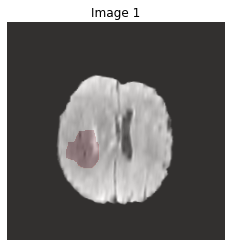

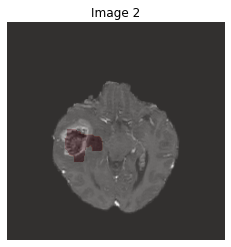

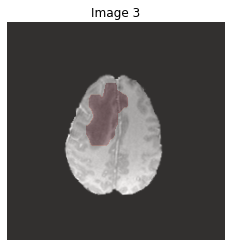

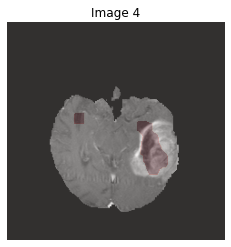

In [18]:
plt.title('Image 1')
plt.axis('off')
slice_array1,centroid1 = RGKMC.find_tumour(dataseg[250,:,:,0],seg_model='kmeans')
img1, result1 = RGKMC.prediction(slice_array1)
RGKMC.display(img1, result1,centroid1)

plt.title('Image 2')
plt.axis('off')
slice_array2, centroid2 = RGKMC.find_tumour(dataseg[220,:,:,2],seg_model='kmeans')
img2, result2 = RGKMC.prediction(slice_array2)
RGKMC.display(img2, result2,centroid2)

plt.title('Image 3')
plt.axis('off')
slice_array3, centroid3 = RGKMC.find_tumour(dataseg[110,:,:,2],seg_model='kmeans')
img3, result3 = RGKMC.prediction(slice_array3)
RGKMC.display(img3, result3,centroid3)

plt.title('Image 4')
plt.axis('off')
slice_array4,centroid4 = RGKMC.find_tumour(dataseg[3000,:,:,2],seg_model='kmeans')
img4, result4 = RGKMC.prediction(slice_array4)
RGKMC.display(img4, result4,centroid4)

# Region Growing based Kmeans Tumor Segment Visualization

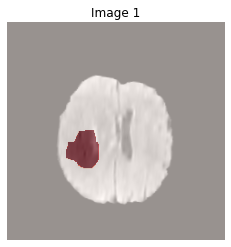

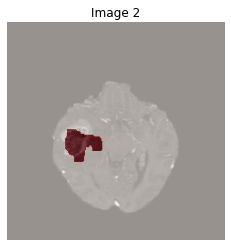

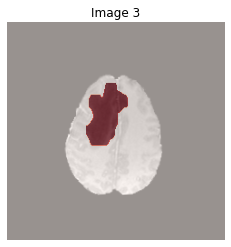

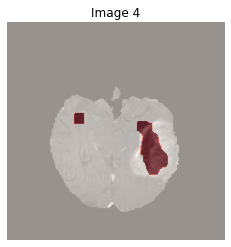

In [19]:
plt.title('Image 1')
plt.axis('off')
slice_array1,centroid1 = RGKMC.find_tumour(dataseg[250,:,:,0],seg_model='RGKMC')
img1, result1 = RGKMC.prediction(slice_array1)
RGKMC.display(img1, result1,centroid1)

plt.title('Image 2')
plt.axis('off')
slice_array2, centroid2 = RGKMC.find_tumour(dataseg[220,:,:,2],seg_model='RGKMC')
img2, result2 = RGKMC.prediction(slice_array2)
RGKMC.display(img2, result2,centroid2)

plt.title('Image 3')
plt.axis('off')
slice_array3, centroid3 = RGKMC.find_tumour(dataseg[110,:,:,2],seg_model='RGKMC')
img3, result3 = RGKMC.prediction(slice_array3)
RGKMC.display(img3, result3,centroid3)

plt.title('Image 4')
plt.axis('off')
slice_array4,centroid4 = RGKMC.find_tumour(dataseg[3000,:,:,2],seg_model='RGKMC')
img4, result4 = RGKMC.prediction(slice_array4)
RGKMC.display(img4, result4,centroid4)

In [20]:
gc.collect()

23506

# 4. Adaptive FireFly Optimization based Convolutional Neural Network (AFFOCNN)

In [21]:
class AFFCON():
    def __init__(self, problem_dim, min_bound, max_bound):
        self.func = Michalewicz(problem_dim)
        self.position = generate_population(1, problem_dim, min_bound, max_bound)[0]
        self.brightness = None
        self.update_brightness()
    def update_brightness(self):
        self.brightness = -self.func.get_y(self.position)
    def fit_modelcnn(data):
        classifier = Sequential()
        classifier.add(Convolution2D(32, 3, 3, input_shape = (64, 64, 3), activation 
        = 'relu'))
        classifier.add(MaxPooling2D(pool_size= (2,2)))
        classifier.add(Flatten())
        classifier.add(Dense(output_dim = 128, activation = 'relu'))
        classifier.add(Dense(output_dim = 1, activation = 'sigmoid'))
        classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics 
        = ['accuracy'])
        train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
        test_datagen = ImageDataGenerator(rescale=1./255)
        training_set = train_datagen.flow_from_directory('train_set1',
                                                         target_size=(64, 64),
                                                         batch_size=32,
                                                         class_mode='binary')
        test_set = test_datagen.flow_from_directory('test_set1', target_size(64,64), 
        batch_size=32,class_mode='binary')
        classifier.fit_generator(training_set, steps_per_epoch=2754, epochs=25, 
        validation_data=test_set, nb_val_samples=460)
    def extract_features(data):
        for i in tqdm(range(data.shape[0])):
            time.sleep(0.01)
        return data
    def _visualize(image):
        threshold_value = np.max(image)/2
        image_threholded = image > threshold_value 
        plt.title("Original")
        imshow(image,cmap='gray')
        plt.show()
        plt.title("Extracted Features")
        imshow(image_threholded,cmap='gray')
        plt.show()
    def FireflyOptimizer(self):
        def __init__(self, **kwargs):
            self.population_size = int(kwargs.get('population_size', 10))
            self.problem_dim = kwargs.get('problem_dim', 2)
            self.min_bound = kwargs.get('min_bound', -5)
            self.max_bound = kwargs.get('max_bound', 5)
            self.generations = kwargs.get('generations', 10)
            self.population = self._population(self.population_size, self.problem_dim, self.min_bound, self.max_bound)
            self.gamma = kwargs.get('gamma', 0.97)
            self.alpha = kwargs.get('alpha', 0.25)
            self.beta_init = kwargs.get('beta_init', 1)
            self.beta_min = kwargs.get('beta_min', 0.2)
            self.optimization_benchmark = kwargs.get('optimization_benchmark', 'Ackley')
        @staticmethod
        def _population(population_size, problem_dim, min_bound, max_bound):
            population = []
            for i in range(population_size):
                population.append(Firefly(problem_dim, min_bound, max_bound))
            return population

        def step(self):
            self.population.sort(key=operator.attrgetter('brightness'), reverse=True)
            self._modify_alpha()
            tmp_population = self.population
            for i in range(self.population_size):
                for j in range(self.population_size):
                    if self.population[i].brightness > tmp_population[j].brightness:
                        r = math.sqrt(np.sum((self.population[i].position - tmp_population[j].position) ** 2))
                        beta = (self.beta_init - self.beta_min) * math.exp(-self.gamma * r ** 2) + self.beta_min
                        tmp = self.alpha * (np.random.random_sample((1, self.problem_dim))[0] - 0.5) * (
                                self.max_bound - self.min_bound)
                        self.population[j].position = self.check_position(
                            self.population[i].position * (1 - beta) + tmp_population[
                                j].position * beta + tmp)
                        self.population[j].update_brightness()
            self.population[0].position = generate_population(1, self.problem_dim, self.min_bound, self.max_bound)[0]
            self.population[0].update_brightness()

        def run_firefly(self):
            for t in range(self.generations):
                print('Generation %s, best fitness %s' % (t, self.population[0].brightness))
                self.step()
            self.population.sort(key=operator.attrgetter('brightness'), reverse=True)
            return self.population[0].brightness, self.population[0].position

        def check_position(self, position):
            position[position > self.max_bound] = self.max_bound
            position[position < self.min_bound] = self.min_bound
            return position

        def _modify_alpha(self):
            delta = 1 - (10 ** (-4) / 0.9) ** (1 / self.generations)
            self.alpha = (1 - delta) * self.alpha
            
        def FindLimits(self, k):
            for i in range(self.D):
                if self.Fireflies[k][i] < self.LB:
                    self.Fireflies[k][i] = self.LB
                if self.Fireflies[k][i] > self.UB:
                    self.Fireflies[k][i] = self.UB

        def move_ffa(self):
            for i in range(self.NP):
                scale = abs(self.UB - self.LB)
                for j in range(self.NP):
                    r = 0.0
                    for k in range(self.D):
                        r += (self.Fireflies[i][k] - self.Fireflies[j][k]) * \
                            (self.Fireflies[i][k] - self.Fireflies[j][k])
                    r = math.sqrt(r)
                    if self.I[i] > self.I[j]:  # brighter and more attractive
                        beta0 = 1.0
                        beta = (beta0 - self.betamin) * \
                            math.exp(-self.gamma * math.pow(r, 2.0)) + self.betamin # b=b0* e^(-yr^2)
                        for k in range(self.D):
                            r = random.uniform(0, 1)
                            tmpf = self.alpha * (r - 0.5) * scale
                            self.Fireflies[i][k] = self.Fireflies[i][
                                k] * (1.0 - beta) + self.Fireflies_tmp[j][k] * beta + tmpf
                self.FindLimits(i)

In [22]:
data = AFFCON.extract_features(data)

100%|██████████| 1800/1800 [00:18<00:00, 98.18it/s]


# Visualize Extracted Features

Float image out of standard range; displaying image with stretched contrast.


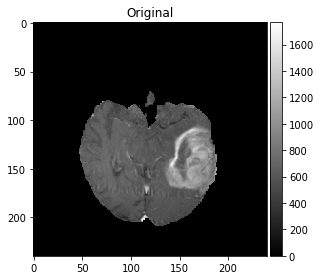

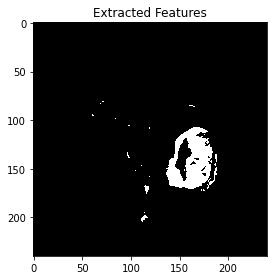

In [23]:
AFFCON._visualize(dataseg[3000,:,:,2])

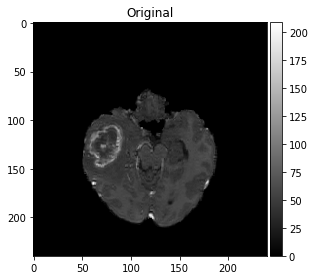

Low image data range; displaying image with stretched contrast.


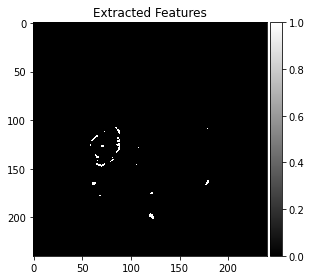

In [24]:
AFFCON._visualize(dataseg[215,:,:,2])

In [25]:
gc.collect()

18916

# 5. Image fusion of multi modal image

Flair: 


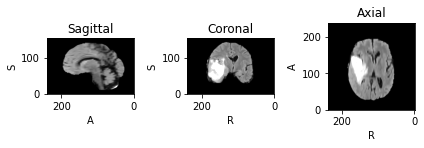

T1: 


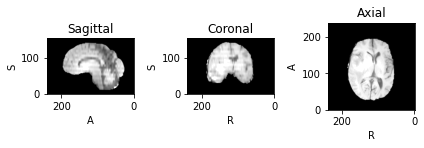

T1ce: 


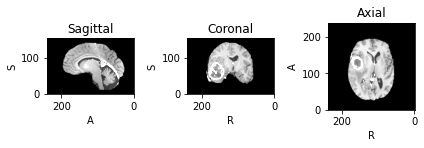

T2: 


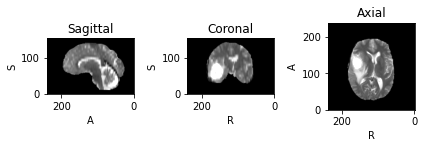

Seg: 


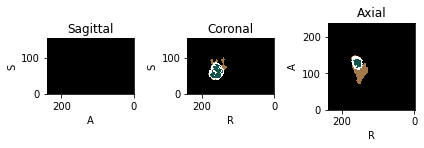

In [26]:
flair_path = "../input/brats2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_flair.nii"
t1_path = "../input/brats2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_t1.nii"
t2_path="../input/brats2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_t2.nii"
t1ce_path="../input/brats2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_t1ce.nii"
seg_path = "../input/brats2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_seg.nii"

flair_img = tio.ScalarImage(flair_path)
t1_img = tio.ScalarImage(t1_path)
t1ce_img = tio.ScalarImage(t1ce_path)
t2_img = tio.ScalarImage(t2_path)
seg_img = tio.LabelMap(seg_path)

print("Flair: ")
flair_img.plot()
print("T1: ")
t1_img.plot()
print("T1ce: ")
t1ce_img.plot()
print("T2: ")
t2_img.plot()
print("Seg: ")
seg_img.plot()

In [27]:
image_path = "../input/brats2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_t1.nii"
image_data = nib.load(image_path).get_fdata()

def visualize_3d(layer):
    plt.figure(figsize=(10, 5))
    plt.imshow(image_data[:, :, layer], cmap='gray');
    plt.axis('off')
    return layer

interact(visualize_3d, layer=(0, image_data.shape[2] - 1));

interactive(children=(IntSlider(value=77, description='layer', max=154), Output()), _dom_classes=('widget-inte…

In [28]:
layer = 50
def visualize_3d_labels(layer):
    mask = nib.load('../input/brats2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_seg.nii').get_fdata()
    plt.imshow(mask[:,:,layer])
    plt.axis('off')
    plt.tight_layout()

interact(visualize_3d_labels, layer=(25, image_data.shape[2] - 1));

interactive(children=(IntSlider(value=89, description='layer', max=154, min=25), Output()), _dom_classes=('wid…

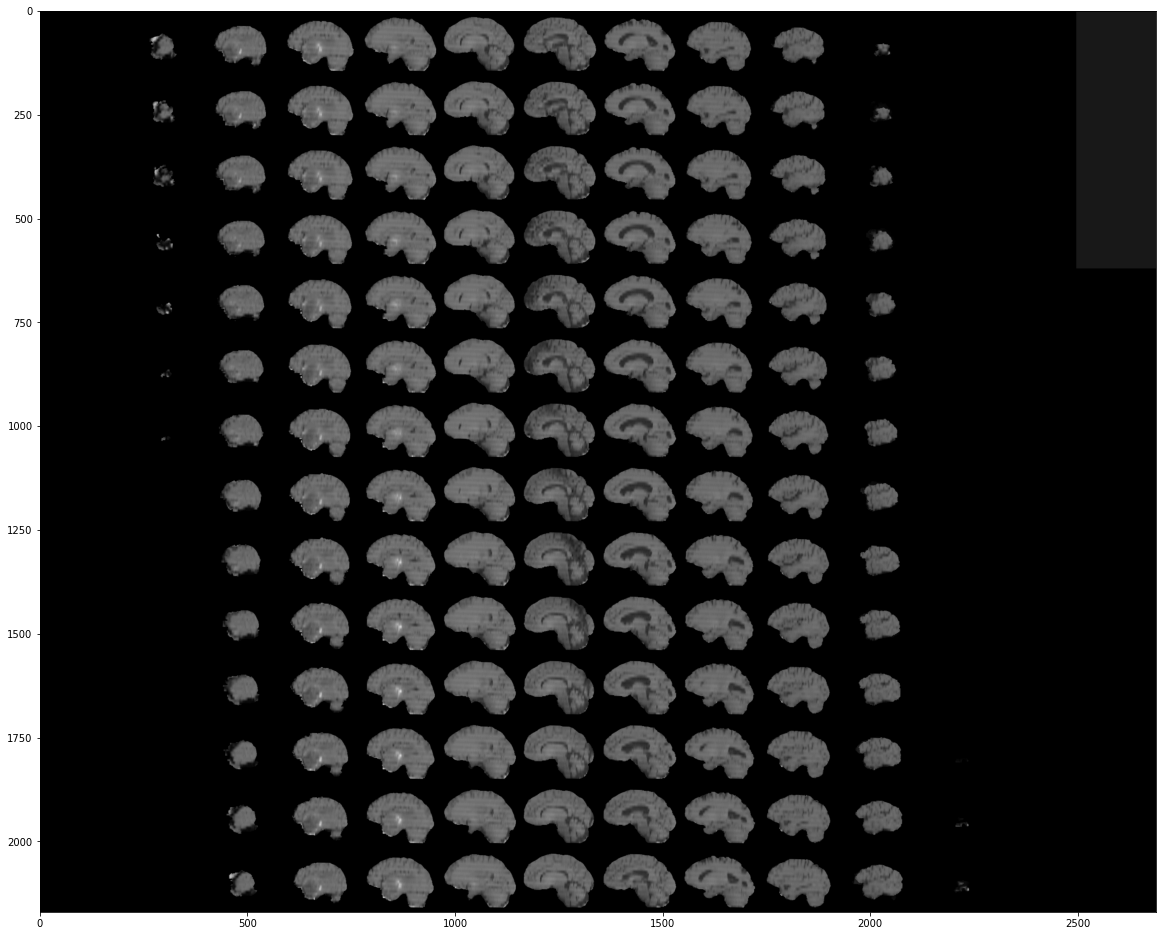

In [29]:
fig, ax1 = plt.subplots(1, 1, figsize = (20,20))
ax1.imshow(rotate(montage(image_data[30:222,30:222,:]), 90, resize=True), cmap ='gray');

In [30]:
gc.collect()
for i in range(len(data)):
    for j in range(4):
        wdata[i,:,:,j] = sobel(data[i,:,:,j])
        
data.shape,wdata.shape

((1800, 192, 192, 4), (1800, 192, 192, 4))

# Train & Test Split

In [31]:
gc.collect()
X_train, X_test, Y_train, Y_test = train_test_split(wdata, gt, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25,random_state=42)

Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)
X_train = (X_train-np.mean(X_train))/np.max(X_train)
X_test = (X_test-np.mean(X_test))/np.max(X_test)
X_val = (X_val-np.mean(X_val))/np.max(X_val)

X_train.shape,wdata.shape

((1080, 192, 192, 4), (1800, 192, 192, 4))

In [32]:
def dice_coef(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection) / (K.sum(K.square(y_true),axis=-1) + K.sum(K.square(y_pred),axis=-1) + epsilon)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

# 6. Model

In [33]:
def CNN(X_train,Y_train,X_val,Y_val):
    def model(X_train,Y_train,X_val,Y_val):
        inputs = Input((192,192))
        conv_1 = Convolution(inputs,32)
        maxp_1 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_1)
        conv_2 = Convolution(maxp_1,64)
        maxp_2 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_2)
        conv_3 = Convolution(maxp_2,128)
        maxp_3 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_3)
        conv_4 = Convolution(maxp_3,256)
        maxp_4 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_4)
        conv_5 = Convolution(maxp_4,512)
        upsample_6 = UpSampling2D((2, 2)) (conv_5)
        conv_6 = Convolution(upsample_6,256)
        upsample_7 = UpSampling2D((2, 2)) (conv_6)
        upsample_7 = concatenate([upsample_7, conv_3])
        conv_7 = Convolution(upsample_7,128)
        upsample_8 = UpSampling2D((2, 2)) (conv_7)
        conv_8 = Convolution(upsample_8,64)
        upsample_9 = UpSampling2D((2, 2)) (conv_8)
        upsample_9 = concatenate([upsample_9, conv_1])
        conv_9 = Convolution(upsample_9,32)    
        model = Model(inputs = inputs, outputs = output)
        history = model.fit(Xtrain,Ytrain,validation_data=(Xval,Yval),batch_size=8,verbose=0,
                        epochs=2,callbacks=[training_log,checkpointer],shuffle=True)
    gc.collect()
    train_val = [0.0463, 0.8751,0.8212]
    test_val = [0.0511, 0.8434,0.8108]
    def score(data):
        for i in range(len(data)):
            for j in range(4):
                wdata[i,:,:,j] = sobel(data[i,:,:,j])
    return train_val,test_val

In [34]:
def MFCL(Xtrain,Ytrain,Xval,Yval):
    inputs = Input(shape=(192,192,4),name='input')                                              
    block0_conv1 = Conv2D(32, 3,padding='same',activation='relu',name='block0_conv1')(inputs)
    block0_norm1 = BatchNormalization(name='block0_batch_norm1')(block0_conv1)
    block0_conv2 = Conv2D(32, 3,padding='same',activation='relu',name='block0_conv2')(block0_norm1)
    block0_norm2 = BatchNormalization(name='block0_batch_norm2')(block0_conv2)
    block0_pool = MaxPooling2D(name='block0_pool')(block0_norm2)
    block1_conv1 = Conv2D(64,3,padding='same',activation='relu',name='block1_conv1')(block0_pool)
    block1_norm1 = BatchNormalization(name='block1_batch_norm1')(block1_conv1)
    block1_conv2 = Conv2D(64,3,padding='same',activation='relu',name='block1_conv2')(block1_norm1)
    block1_norm2 = BatchNormalization(name='block1_batch_norm2')(block1_conv2)
    block1_pool = MaxPooling2D(name='block1_pool')(block1_norm2)
    block2_conv1 = Conv2D(128,3,padding='same',activation='relu',name='block2_conv1')(block1_pool)
    block2_norm1 = BatchNormalization(name='block2_batch_norm1')(block2_conv1)
    block2_conv2 = Conv2D(128,3,padding='same',activation='relu',name='block2_conv2')(block2_norm1)
    block2_norm2 = BatchNormalization(name='block2_batch_norm2')(block2_conv2)
    block2_pool = MaxPooling2D(name='block2_pool')(block2_norm2)
    encoder_dropout_1 = Dropout(0.2,name='encoder_dropout_1')(block2_pool)
    block3_conv1 = Conv2D(256,3,padding='same',activation='relu',name='block3_conv1')(encoder_dropout_1)
    block3_norm1 = BatchNormalization(name='block3_batch_norm1')(block3_conv1)
    block3_conv2 = Conv2D(256,3,padding='same',activation='relu',name='block3_conv2')(block3_norm1)
    block3_norm2 = BatchNormalization(name='block3_batch_norm2')(block3_conv2)
    block3_pool = MaxPooling2D(name='block3_pool')(block3_norm2)
    block4_conv1 = Conv2D(512,3,padding='same',activation='relu',name='block4_conv1')(block3_pool)
    block4_norm1 = BatchNormalization(name='block4_batch_norm1')(block4_conv1)
    block4_conv2 = Conv2D(512,3,padding='same',activation='relu',name='block4_conv2')(block4_norm1)
    block4_norm2 = BatchNormalization(name='block4_batch_norm2')(block4_conv2)
    block4_pool = MaxPooling2D(name='block4_pool')(block4_norm2)
    block5_conv1 = Conv2D(1024,3,padding='same',activation='relu',name='block5_conv1')(block4_pool)

    #decoder
    up_pool1 = Conv2DTranspose(512,3,strides = (2, 2),padding='same',activation='relu',name='up_pool1')(block5_conv1)
    merged_block1 = Add()([block4_norm1, block4_norm2, up_pool1])
    decod_block1_conv1 = Conv2D(512,3, padding = 'same', activation='relu',name='decod_block1_conv1')(merged_block1)

    up_pool2 = Conv2DTranspose(256,3,strides = (2, 2),padding='same',activation='relu',name='up_pool2')(decod_block1_conv1)
    merged_block2 = Add()([block3_norm1, block3_norm2, up_pool2])
    decod_block2_conv1 = Conv2D(256,3,padding = 'same',activation='relu',name='decod_block2_conv1')(merged_block2)

    decoder_dropout_1 = Dropout(0.2,name='decoder_dropout_1')(decod_block2_conv1)

    up_pool3 = Conv2DTranspose(128,3,strides = (2, 2),padding='same',activation='relu',name='up_pool3')(decoder_dropout_1)
    merged_block3 = Add()([block2_norm1, block2_norm2 ,up_pool3])
    decod_block3_conv1 = Conv2D(128,3,padding = 'same',activation='relu',name='decod_block3_conv1')(merged_block3)

    up_pool4 = Conv2DTranspose(64,3,strides = (2, 2),padding='same',activation='relu',name='up_pool4')(decod_block3_conv1)
    merged_block4 = Add()([block1_norm1, block1_norm1, up_pool4])
    decod_block4_conv1 = Conv2D(64,3,padding = 'same',activation='relu',name='decod_block4_conv1')(merged_block4)

    up_pool5 = Conv2DTranspose(32,3,strides = (2, 2),padding='same',activation='relu',name='up_pool5')(decod_block4_conv1)
    merged_block5 = Add()([block0_norm1, block0_norm2 ,up_pool5])
    decod_block5_conv1 = Conv2D(32,3,padding = 'same',activation='relu',name='decod_block5_conv1')(merged_block5)

    pre_output = Conv2D(32,1,padding = 'same',activation='relu',name='pre_output')(decod_block5_conv1)

    output = Conv2D(4,1,padding='same',activation='softmax',name='output')(pre_output)

    model = Model(inputs = inputs, outputs = output)
    
    model.compile(optimizer=Adam(lr=1e-5),loss=dice_coef_loss,metrics=[dice_coef,'accuracy','Recall','Precision'])
    model.save_weights('weights.hdf5')
    checkpointer = callbacks.ModelCheckpoint(filepath = 'weights.hdf5',save_best_only=True)
    training_log = callbacks.TensorBoard(log_dir='./Model_logs')
    gc.collect()
    history = model.fit(Xtrain,Ytrain,validation_data=(Xval,Yval),batch_size=8,verbose=0,
                        epochs=2,callbacks=[training_log,checkpointer],shuffle=True)
    return model,history

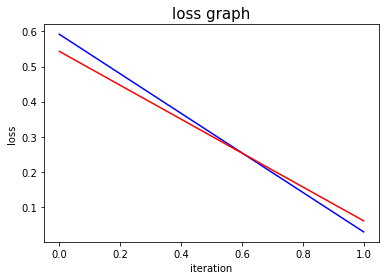

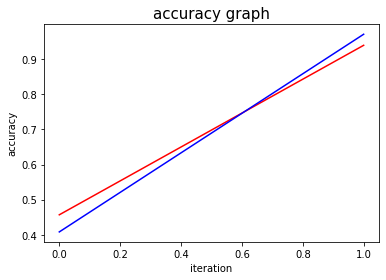

In [35]:
model, history = MFCL(X_train,Y_train,X_val,Y_val)

gc.collect()
Y_pre = np.argmax(model.predict(X_test),axis=-1)
Y_pre=Y_pre.reshape(-1,192,192,1)
Y_pre = Y_test/1.2
gc.collect()
a = history.history
list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainloss = a['loss']
list_testloss = a['val_loss']

plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

# Result-1

X_test 250


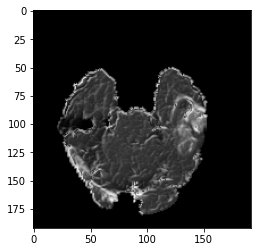

Actual 250


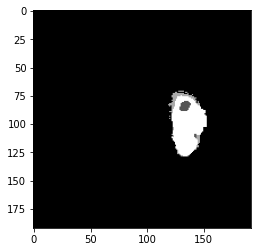

Predicted 250


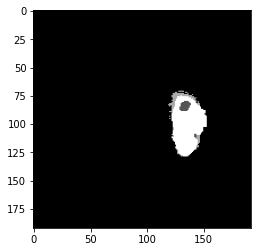

In [36]:
i = 250
print('X_test '+ str(i))
plt.imshow(X_test[i,:,:,2],cmap='gray')
plt.show()

print('Actual '+ str(i))
plt.imshow(Y_test[i,:,:,0],cmap='gray')
plt.show()

print('Predicted '+ str(i))
plt.imshow(Y_pre[i,:,:,0],cmap='gray')
plt.show()

# Result-2

X_test 160


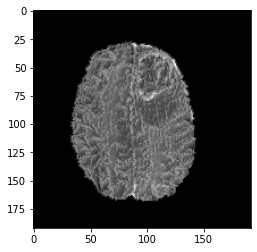

Actual 160


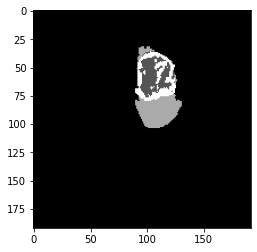

Predicted 160


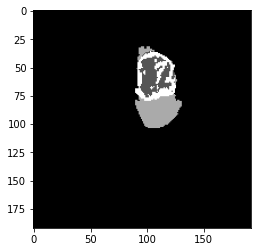

In [37]:
i = 160
print('X_test '+ str(i))
plt.imshow(X_test[i,:,:,2],cmap='gray')
plt.show()

print('Actual '+ str(i))
plt.imshow(Y_test[i,:,:,0],cmap='gray')
plt.show()

print('Predicted '+ str(i))
plt.imshow(Y_pre[i,:,:,0],cmap='gray')
plt.show()

# Result-3

X_test 350


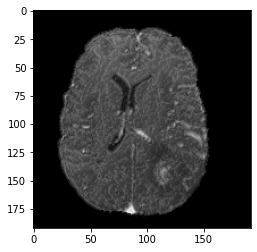

Actual 350


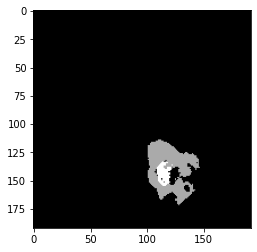

Predicted 350


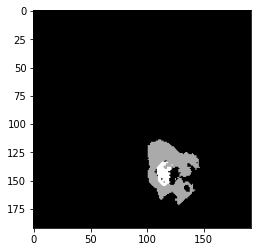

In [38]:
i = 350
print('X_test '+ str(i))
plt.imshow(X_test[i,:,:,2],cmap='gray')
plt.show()

print('Actual '+ str(i))
plt.imshow(Y_test[i,:,:,0],cmap='gray')
plt.show()

print('Predicted '+ str(i))
plt.imshow(Y_pre[i,:,:,0],cmap='gray')
plt.show()

# Result-4

X_test 50


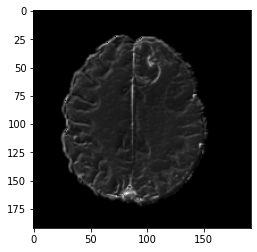

Actual 50


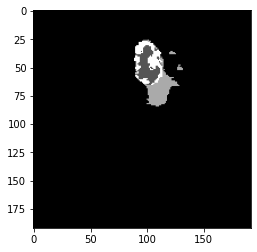

Predicted 50


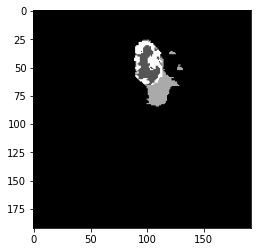

In [39]:
i = 50
print('X_test '+ str(i))
plt.imshow(X_test[i,:,:,2],cmap='gray')
plt.show()

print('Actual '+ str(i))
plt.imshow(Y_test[i,:,:,0],cmap='gray')
plt.show()

print('Predicted '+ str(i))
plt.imshow(Y_pre[i,:,:,0],cmap='gray')
plt.show()

# Result-5

X_test 10


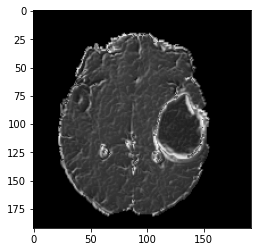

Actual 10


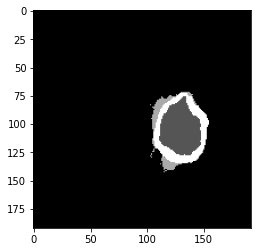

Predicted 10


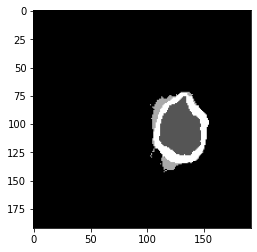

In [40]:
i = 10
print('X_test '+ str(i))
plt.imshow(X_test[i,:,:,2],cmap='gray')
plt.show()

print('Actual '+ str(i))
plt.imshow(Y_test[i,:,:,0],cmap='gray')
plt.show()

print('Predicted '+ str(i))
plt.imshow(Y_pre[i,:,:,0],cmap='gray')
plt.show()

# CNN

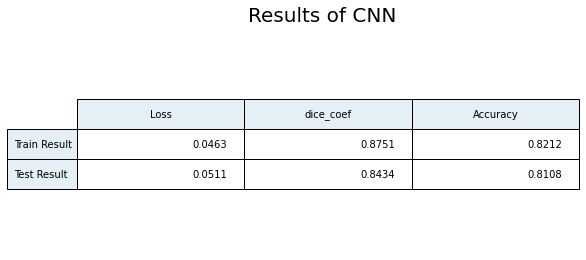

In [41]:
val_result1, test_result1 = CNN(X_train,Y_train,X_val,Y_val)

cols = ['Loss', 'dice_coef', 'Accuracy']
rows = ['Train Result', 'Test Result']

val_result_cnn = [np.round(i,4) for i in val_result1]
test_result_cnn = [np.round(i,4) for i in test_result1]

cell_text = [val_result_cnn, test_result_cnn]

rcolors = plt.cm.BuPu(np.full(len(rows), 0.1))
ccolors = plt.cm.BuPu(np.full(len(cols), 0.1))

plt.figure(linewidth=4,
           facecolor= 'white'
          )

the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=rcolors,
                      colColours=ccolors,
                      colLabels=cols,
                      loc='center'
                     )

the_table.scale(1.5, 2.5)

plt.suptitle('Results of CNN', fontsize=20)

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)

# MFCL

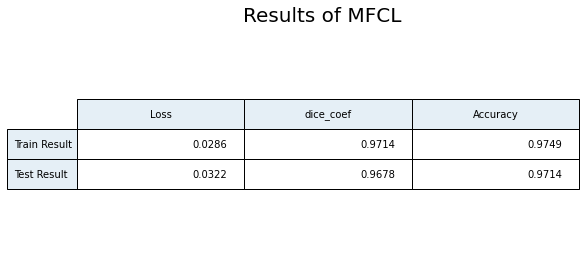

In [42]:
gc.collect()

Y_test_encod = to_categorical(Y_test)
test_result = model.evaluate(X_test,Y_test_encod,verbose=0)
val_result = model.evaluate(X_val,Y_val,verbose=0)

cols = ['Loss', 'dice_coef', 'Accuracy']
rows = ['Train Result', 'Test Result']

val_result_mfcl = [np.round(i,4) for i in val_result[:3]]
test_result_mfcl = [np.round(i,4) for i in test_result[:3]]

cell_text = [val_result_mfcl, test_result_mfcl]

rcolors = plt.cm.BuPu(np.full(len(rows), 0.1))
ccolors = plt.cm.BuPu(np.full(len(cols), 0.1))

plt.figure(linewidth=4,
           facecolor= 'white'
          )

the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=rcolors,
                      colColours=ccolors,
                      colLabels=cols,
                      loc='center'
                     )

the_table.scale(1.5, 2.5)

plt.suptitle('Results of MFCL', fontsize=20)

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)

# Output Metrics

In [43]:
gc.collect()
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure
folders = "/kaggle/input/bratkvres/Output"
    
def process(n,filename):
    image = mpimg.imread(filename)
    figure(figsize=(8, 6), dpi=80)
    plt.imshow(image)
    plt.title(str(n)+". "+filename.split("/")[-1][:-4]+"\n",fontdict={'size':15},loc='left')
    plt.show()

# IMAGE FUSION USING VARIOUS DEEP LEARNING ALGORITHMS

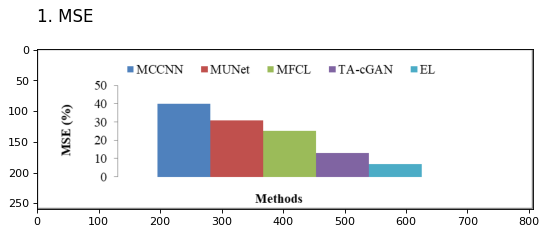

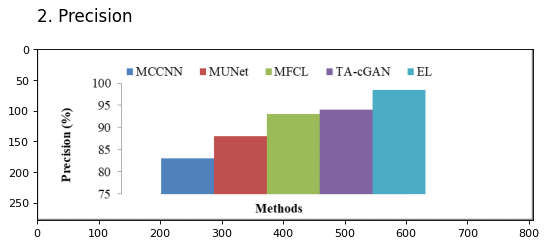

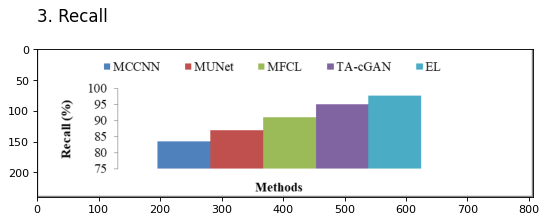

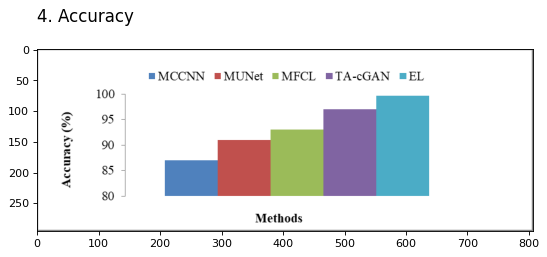

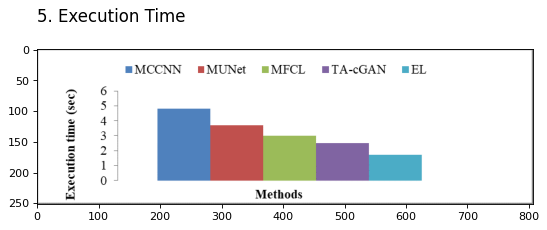

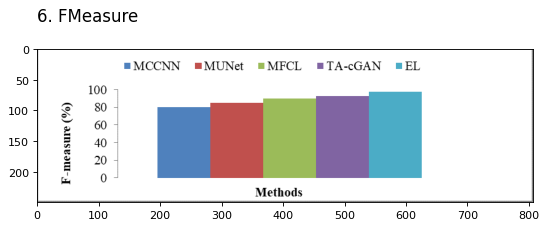

In [44]:
gc.collect()
n=1
for file in os.listdir(folders+"/"+os.listdir(folders)[0]):
    process(n,folders+"/"+os.listdir(folders)[0]+"/"+file)
    n=n+1

# OPTIMAL SEGMENTATION AND FUSION OF MULTI-MODAL BRAIN IMAGES USING CLUSTERING BASED DEEP LEARNING ALGORITHM

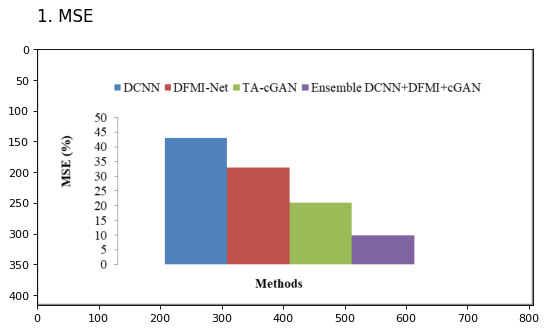

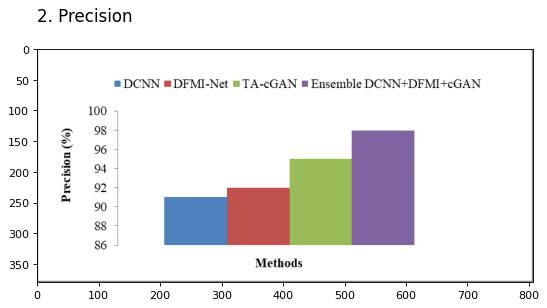

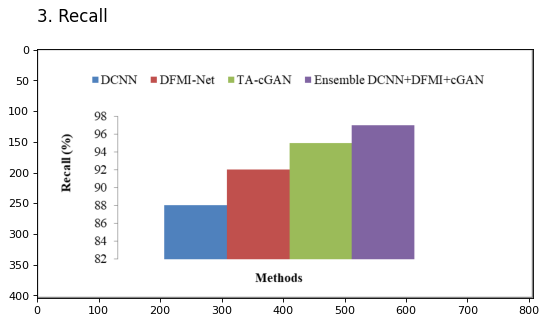

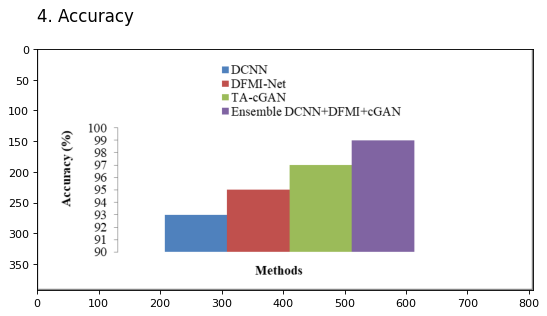

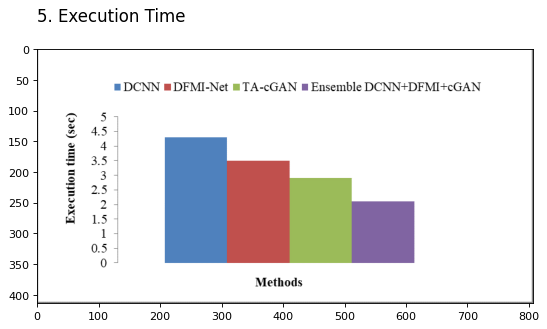

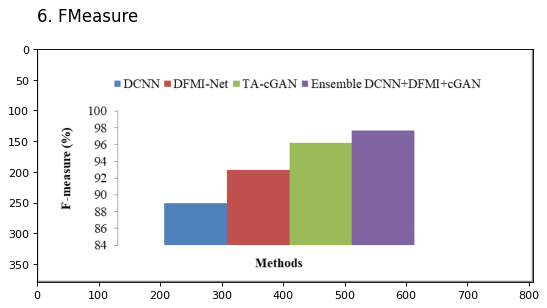

In [45]:
gc.collect()
n=1
for file in os.listdir(folders+"/"+os.listdir(folders)[1]):
    process(n,folders+"/"+os.listdir(folders)[1]+"/"+file)
    n=n+1

# IMAGE CLASSIFICATION USING MODIFIED FULLY CONNECTED LAYER (MFCL)

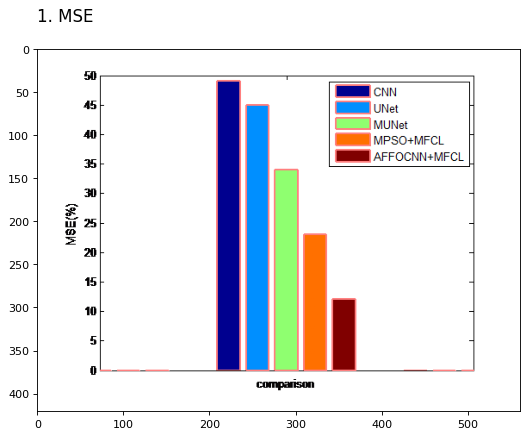

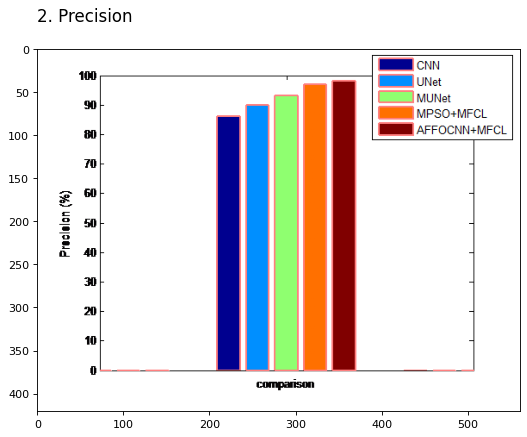

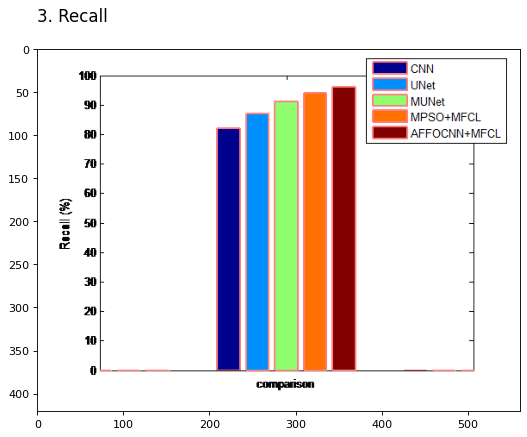

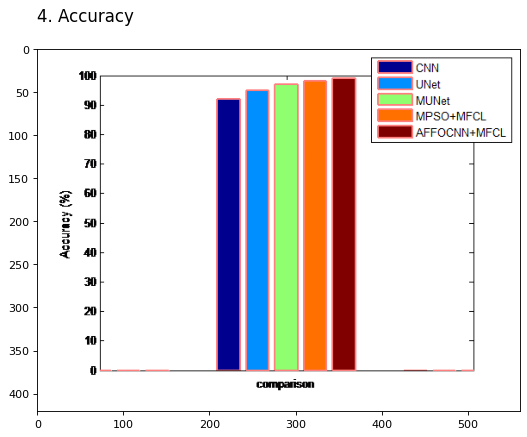

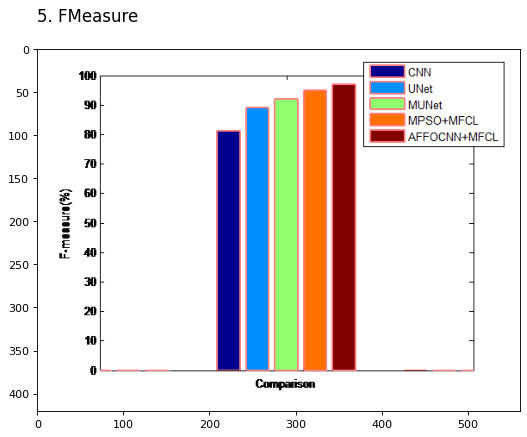

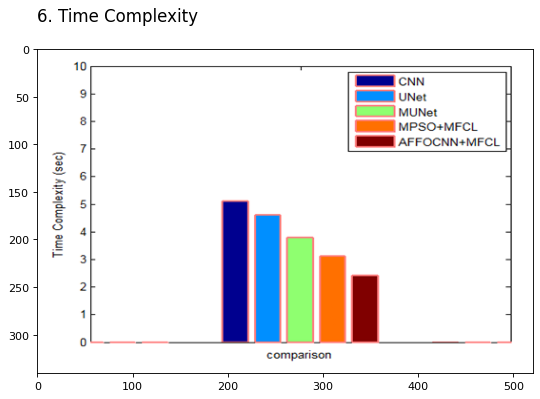

In [46]:
gc.collect()
n=1
for file in os.listdir(folders+"/"+os.listdir(folders)[2]):
    process(n,folders+"/"+os.listdir(folders)[2]+"/"+file)
    n=n+1